In [167]:
import datetime
import numpy as np
import pandas as pd
import random

from scipy.signal import find_peaks

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

%matplotlib inline

import vasu

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [168]:
STOCK_NAME = 'HPCL'
STOCK_PRICE_FILE = './../database/500104.csv'

In [169]:
price_data = pd.read_csv(STOCK_PRICE_FILE,index_col = 0, parse_dates = True,
                             usecols = [u'Date',u'Open Price', u'High Price', u'Low Price', u'Close Price'],
                             dtype= {u'Open Price':np.float64,u'High Price':np.float64,
                                     u'Low Price':np.float64,u'Close Price':np.float64}).sort_index()

In [170]:
sample_data = price_data.loc[datetime.date(year=2017,month=7,day=11):datetime.date(year=2017,month=9,day=11)]

In [171]:
trend_data = vasu.get_trend_data(sample_data)

In [172]:
def split_data(dataframe):
    train_data = dataframe[(dataframe['high_slope'].notnull()) | (dataframe['low_slope'].notnull())].copy()
    test_data = dataframe[~((dataframe['high_slope'].notnull()) | (dataframe['low_slope'].notnull()))].copy()
    return train_data,test_data

In [173]:
train_data,test_data = split_data(trend_data)

In [176]:
def get_latest_peak_info(dataframe):
    return_dict = {}
    high_data = dataframe[dataframe['high_slope'].notnull()].tail(1)
    low_data = dataframe[dataframe['low_slope'].notnull()].tail(1)
    latest_high_date = high_data.index.to_pydatetime()[0]
    latest_low_date = low_data.index.to_pydatetime()[0]

    if latest_high_date > latest_low_date:
        return_dict['peak_type'] = 'high'
        return_dict['peak_data'] = high_data
    elif latest_high_date < latest_low_date:
        return_dict['peak_type'] = 'low'
        return_dict['peak_data'] = low_data
    else:
        return_dict['peak_type'] = 'high&low'
        return_dict['peak_data'] = low_data
    
    return return_dict

In [182]:
peak_info =  get_latest_peak_info(train_data)
peak_type = peak_info['peak_type']
peak_data = peak_info['peak_data']

In [201]:
peak_date = peak_data.index.to_pydatetime()[0]
trend_before_peak = peak_data['trend'].values[0]
peak_high_slope = peak_data['high_slope'].values[0]
peak_low_slope = peak_data['low_slope'].values[0]
peak_high = peak_data['High Price'].values[0]
peak_low = peak_data['Low Price'].values[0]

### Higher high after bullish or sideways trend

In [219]:
if (peak_type == 'high') and (peak_high_slope > 0.0) and (trend_before_peak != 'bearish'):
    low_mark_price = peak_low
    signal_data = test_data[test_data['Close Price'] < low_mark_price][1:2].copy()

In [221]:
if len(signal_data) > 0:
    print('Sell!')
    print('Benchmark Price is : %.2f' % low_mark_price)
    print('Signal Date is : %s' % signal_data.index.to_pydatetime()[0])
    print('Closing Price on signal is : %.2f' % signal_data['Close Price'].values)

Sell!
Benchmark Price is : 479.50
Signal Date is : 2017-09-06 00:00:00
Closing Price on signal is : 476.05


In [222]:
signal_to_end_data = trend_data.loc[peak_date:].copy()
signal_to_end_data['benchmark price'] = low_mark_price
benchmark_series = signal_to_end_data['benchmark price']

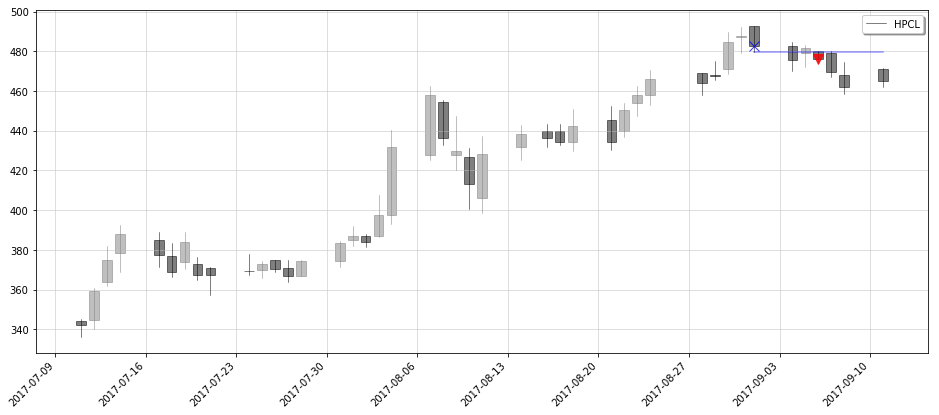

In [223]:
fig, ax = plt.subplots(figsize = (16,7))
fig.subplots_adjust(bottom=0.2)

quotes = zip(mdates.date2num(sample_data.index.to_pydatetime()),sample_data[u'Open Price'], 
                             sample_data[u'High Price'],sample_data[u'Low Price'], sample_data[u'Close Price'])
candlestick_ohlc(ax,quotes,width=0.75,colorup='grey',colordown='black' ,alpha=0.5)

plt.plot(benchmark_series, "-", color='blue', alpha = 0.4)
plt.plot(signal_data['Close Price'], "v", color='red',markersize=10,alpha = 0.8)
plt.plot(peak_data['Close Price'], "x", color='b',markersize=10, alpha = 0.8)

ax.xaxis_date()
ax.legend([STOCK_NAME],loc='upper right', shadow=True, fancybox=True)
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
plt.show()